In [1]:
import os
import json
import openai
import asyncio
import numpy as np
import nest_asyncio
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, models

from src.data_processor import translate_and_convert_to_string, process_vision_result, extract_workstyle_info
from src.prompt_processor import generate_vision_prompt, generate_workstyle_prompt, generate_summary_prompt
from src.openai_processor import chatgpt_response

In [2]:
nest_asyncio.apply()
DATA_PATH = "./data/comments_sample.json"
GT_PATH = "./data/amy_gt.json"

N_ITER = 100 ## 50, 100
THRESHOLD = 0.7
EMBEDDING_MODEL_ID = "nlpai-lab/KoE5" ## "dragonkue/bge-m3-ko, "dragonkue/bge-m3-ko"

In [3]:
with open(DATA_PATH, 'r', encoding='utf-8') as file:
    hr_data_dict = json.load(file)

with open(GT_PATH, 'r', encoding="utf-8") as file:
    gt_data_dict = json.load(file)

In [4]:
hr_data_dict

{'visionResult': {'company': {'keyWord': {'혁신': 5.0,
    '도전': 5.0,
    '사회공헌': 3.2,
    '즐거움': 3.5,
    '창조': 5.0,
    '전문성': 3.7}},
  'compute': {'keyWord': {'문제해결': 0.0,
    '상생': 2.5,
    '혁신': 3.64,
    '사회공헌': 1.67,
    '고객': 2.0,
    '즐거움': 2.22,
    '창조': 5.0,
    '성장': 3.08,
    '인재': 3.25,
    '소통': 2.31,
    '성과': 3.08,
    '최고지향': 3.13,
    '도전': 3.85,
    '신속성': 1.92,
    '열정': 2.5,
    '전문성': 1.36}}},
 'workstyleResult': {'company': {'keyWord': {'촉진자형': 5.0,
    '분석형': 5.0,
    '조력자형': 5.0,
    '논리형': 5.0,
    '협력형': 5.0,
    '겸손형': 5.0},
   'totalScore': 30.0},
  'compute': {'keyWord': {'촉진자형': 2.14,
    '분석형': 2.6,
    '조력자형': 1.88,
    '논리형': 2.22,
    '협력형': 3.08,
    '겸손형': 2.14},
   'totalScore': 14.06},
  'rate': 0.0},
 'summaryResult': {'additionalInformation': {'조기 퇴사 가능성': '보통',
   '입사 후 적응 기간': '짧음',
   '채용 권장 수준': '짧음'},
  'fued': ['과몰입형'],
  'recruitentQuestions': {'5) 사고방식이 기업 비전,가치관에 부합하는가?': '보통이다',
   '2) 타 팀, 타 구성원과의 원만한 협업을 기대할 수 있는가?': '아니다',
   '3) 경영

In [5]:
processed_data_summary = translate_and_convert_to_string(hr_data_dict['summaryResult'])
vision_data = process_vision_result(hr_data_dict['visionResult'], hr_data_dict['summaryResult'])
workstyle_data = extract_workstyle_info(hr_data_dict['workstyleResult'], hr_data_dict['summaryResult'])

In [6]:
vision_prompt = generate_vision_prompt(vision_data)
workstyle_prompt = generate_workstyle_prompt(workstyle_data)
summary_prompt = generate_summary_prompt(processed_data_summary)

In [7]:
async def generate_comments(prompts, num_samples=3):
    results = []
    for i in range(num_samples):
        vision_comment, workstyle_comment, summary_comment = await asyncio.gather(
            chatgpt_response(prompts["vision_prompt"]),
            chatgpt_response(prompts["workstyle_prompt"]),
            chatgpt_response(prompts["summary_prompt"]),
        )
        results.append({
            "vision_comment": vision_comment,
            "workstyle_comment": workstyle_comment,
            "summary_comment": summary_comment
        })
    return results

In [8]:
prompts = {
    "vision_prompt": generate_vision_prompt(vision_data),
    "workstyle_prompt": generate_workstyle_prompt(workstyle_data),
    "summary_prompt": generate_summary_prompt(processed_data_summary)
}

In [9]:
loop = asyncio.get_event_loop()
comments = loop.run_until_complete(generate_comments(prompts, num_samples=N_ITER))

In [10]:
df = pd.DataFrame(comments)

os.makedirs('./result', exist_ok=True)
df.to_csv(f"./result/comments_{N_ITER}.csv", index=False)

In [11]:
df = pd.read_csv(f"./result/comments_{N_ITER}.csv")

In [12]:
model = SentenceTransformer(EMBEDDING_MODEL_ID)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/165 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.71k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

def create_tsne_visualizations(df, gt_data_dict, model, N_ITER, THRESHOLD=0.8):
    # 서브플롯 생성
    fig = plt.figure(figsize=(15, 5))
    
    # 각 comment 타입에 대한 시각화
    comment_types = ['vision_comment', 'workstyle_comment', 'summary_comment']
    gt_types = ['vision_comment', 'workstyle_comment', 'summary_comment']
    
    # 유사도 분석 결과를 저장할 딕셔너리
    similarity_results = {}
    
    for idx, (comment_type, gt_type) in enumerate(zip(comment_types, gt_types), 1):
        # 임베딩 생성
        embeddings = model.encode(df[comment_type].tolist())
        gt_embeddings = model.encode([gt_data_dict[gt_type]])
        
        # 코사인 유사도 계산
        similarities = cosine_similarity(embeddings, gt_embeddings)
        
        # 임계값 이상인 임베딩 개수 계산
        above_threshold = np.sum(similarities >= THRESHOLD)
        
        # 결과 저장
        similarity_results[comment_type] = {
            'mean_similarity': np.mean(similarities),
            'above_threshold': above_threshold,
            'total_samples': len(similarities)
        }
        
        # 데이터와 GT 임베딩 합침
        all_embeddings = np.vstack([embeddings, gt_embeddings])
        
        # t-SNE perplexity 조정
        perplexity = min(30, len(all_embeddings) - 1)
        
        # t-SNE 변환
        tsne = TSNE(n_components=3, random_state=42, perplexity=perplexity)
        reduced_embeddings_tsne = tsne.fit_transform(all_embeddings)
        
        # 데이터 분리
        data_tsne = reduced_embeddings_tsne[:-1]  # 데이터 부분
        gt_tsne = reduced_embeddings_tsne[-1:]    # GT 부분
        
        # 서브플롯 추가
        ax = fig.add_subplot(1, 3, idx, projection='3d')
        
        # 임계값 기준으로 색상 구분
        colors = ['darkblue' if sim >= THRESHOLD else 'lightblue' for sim in similarities.flatten()]
        
        # 데이터 시각화 (임계값에 따른 색상)
        scatter = ax.scatter(
            data_tsne[:, 0],
            data_tsne[:, 1],
            data_tsne[:, 2],
            c=colors,
            label=f'comments_{N_ITER}'
        )
        
        # GT 시각화 (빨간색)
        ax.scatter(
            gt_tsne[:, 0],
            gt_tsne[:, 1],
            gt_tsne[:, 2],
            color='red',
            label='GT'
        )
        
        title = f"{comment_type.split('_')[0].capitalize()}\n"
        title += f"Similar: {above_threshold}/{len(similarities)}"
        ax.set_title(title)
        ax.set_xlabel("Dimension 1")
        ax.set_ylabel("Dimension 2")
        ax.set_zlabel("Dimension 3")
        ax.legend()
    
    # 플롯 간격 조정
    plt.tight_layout()
    
    # 저장 및 출력
    output_path = f'outputs/{N_ITER}_combined_tSNE.png'
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.show()
    
    # 유사도 분석 결과 출력
    print(f"\nSimilarity Analysis (Threshold: {THRESHOLD}):")
    for comment_type, results in similarity_results.items():
        print(f"\n{comment_type}:")
        print(f"Mean Similarity: {results['mean_similarity']:.4f}")
        print(f"Samples above threshold: {results['above_threshold']}/{results['total_samples']}")
        print(f"Percentage: {(results['above_threshold']/results['total_samples']*100):.2f}%")
    
    return fig, similarity_results

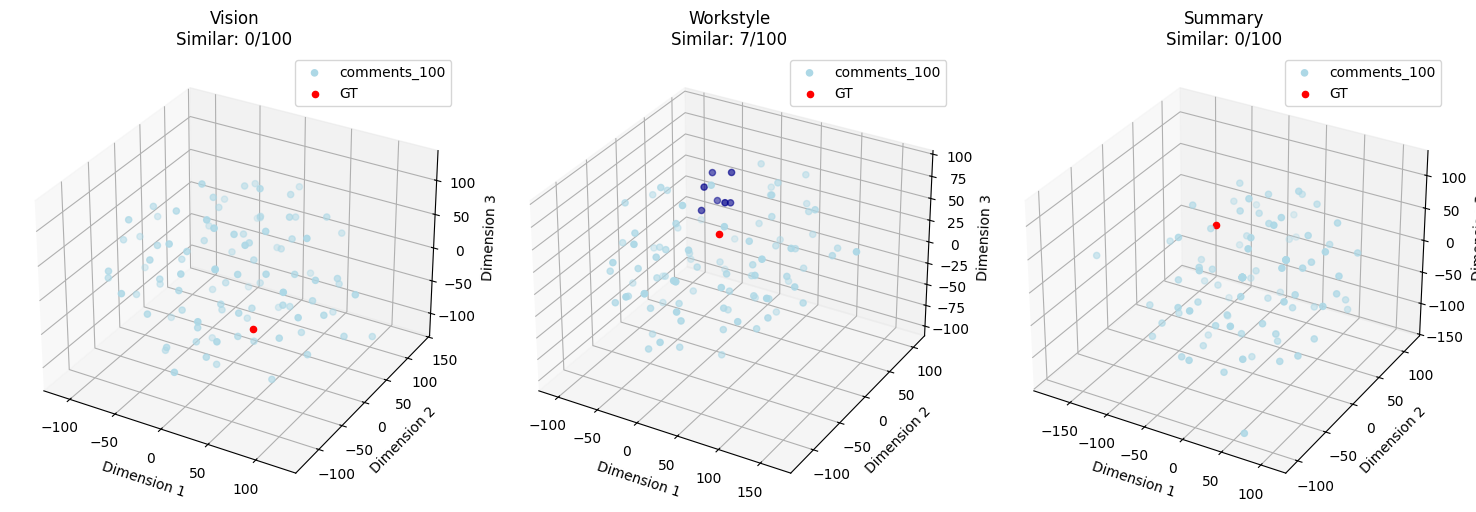


Similarity Analysis (Threshold: 0.7):

vision_comment:
Mean Similarity: 0.5769
Samples above threshold: 0/100
Percentage: 0.00%

workstyle_comment:
Mean Similarity: 0.5569
Samples above threshold: 7/100
Percentage: 7.00%

summary_comment:
Mean Similarity: 0.4534
Samples above threshold: 0/100
Percentage: 0.00%


In [14]:
fig, sim = create_tsne_visualizations(df, gt_data_dict, model, N_ITER, THRESHOLD)